In [2]:
!pip install MetaTrader5
!pip install pandas
!pip install mplfinance
!pip install matplotlib
!pip install xlsxwriter

In [3]:
#data collection
import MetaTrader5 as mt5
import pandas as pd
from datetime import datetime

# Initialize MT5
if not mt5.initialize():
    print("initialize() failed, error code =", mt5.last_error())
    quit()

print("MetaTrader5 package author: ", mt5.__author__)
print("MetaTrader5 package version: ", mt5.__version__)

# Set the symbol
symbol = "XAUUSD.sd"
timeframe = mt5.TIMEFRAME_M5  # 5 minutes

# Check if symbol is available
symbol_info = mt5.symbol_info(symbol)
if symbol_info is None:
    print(f"{symbol} not found, trying alternative symbols...")
    # Try common alternatives
    alternatives = ["XAUUSD", "GOLD", "XAUUSD.a", "XAUUSDm"]
    for alt in alternatives:
        symbol_info = mt5.symbol_info(alt)
        if symbol_info is not None:
            symbol = alt
            print(f"Using symbol: {symbol}")
            break
    
    if symbol_info is None:
        print("No valid XAUUSD symbol found")
        mt5.shutdown()
        quit()

# Enable symbol in Market Watch if needed
if not symbol_info.visible:
    print(f"Enabling {symbol} in Market Watch")
    if not mt5.symbol_select(symbol, True):
        print("Failed to select symbol")
        mt5.shutdown()
        quit()

# Get historical data (last 10000 bars)
print(f"Downloading {symbol} data...")
rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, 50000)

# Shutdown MT5 connection
mt5.shutdown()

if rates is None:
    print("Failed to get rates, error code =", mt5.last_error())
else:
    # Convert to DataFrame
    data = pd.DataFrame(rates)
    
    # Convert time to readable datetime format
    data['time'] = pd.to_datetime(data['time'], unit='s')
    
    # Rename columns to match yfinance format
    data.rename(columns={
        'time': 'Date',
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'tick_volume': 'Volume'
    }, inplace=True)
    
    # Set Date as index
    data.set_index('Date', inplace=True)
    
    # Remove unnecessary columns
    if 'spread' in data.columns:
        data.drop('spread', axis=1, inplace=True)
    if 'real_volume' in data.columns:
        data.drop('real_volume', axis=1, inplace=True)
    
    # Save to CSV
    data.to_csv(r'C:\Users\shivk\Downloads\XAUUSDV1.csv')
    
    print(f"Data saved successfully!")
    print(f"Total bars: {len(data)}")
    print(f"Date range: {data.index[0]} to {data.index[-1]}")
    print("\nFirst few rows:")
    print(data.head())
    print("\nLast few rows:")
    print(data.tail())

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.5370
Data saved successfully!
Total bars: 50000
Date range: 2025-02-13 22:30:00 to 2025-10-28 17:20:00

First few rows:
                        Open     High      Low    Close  Volume
Date                                                           
2025-02-13 22:30:00  2925.89  2927.78  2925.74  2927.16    1338
2025-02-13 22:35:00  2927.15  2928.01  2926.82  2927.66    1192
2025-02-13 22:40:00  2927.65  2928.54  2927.41  2927.72     951
2025-02-13 22:45:00  2927.74  2927.85  2924.80  2926.63    1327
2025-02-13 22:50:00  2926.64  2927.85  2926.16  2927.74    1498

Last few rows:
                        Open     High      Low    Close  Volume
Date                                                           
2025-10-28 17:00:00  3938.76  3942.49  3938.68  3941.03    3881
2025-10-28 17:05:00  3941.04  3944.59  3939.86  3940.93    3567
2025-10-28 17:10:00  3940.98  3944.08  3934.82  3938.91    4221
2025-10-28 17:15:

Loaded 50000 candles
Date range: 2025-02-13 22:30:00 to 2025-10-28 17:20:00

===== Backtest Summary =====
             Metric      Value
0  Starting Balance   50000.00
1     Final Balance -171200.00
2      Total Trades    5939.00
3              Wins    1611.00
4            Losses    4328.00
5             Win %      27.13

Total P&L: $-221200.0
Results exported to XAUUSD_Backtest_ResultsV1.xlsx


C:\Users\shivk\anaconda3\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


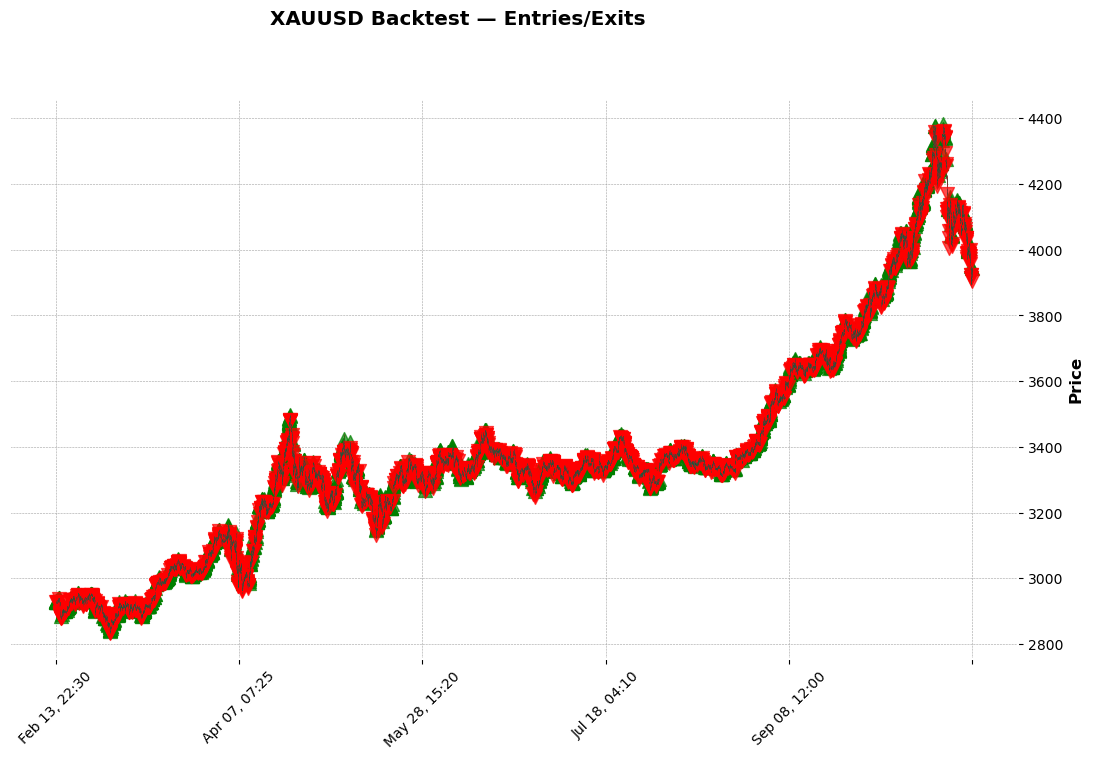

In [4]:
#Unedited strategy
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt

# ========================
# 1. LOAD YOUR DATA
# ========================
data = pd.read_csv(r"C:\Users\shivk\Downloads\XAUUSDV1.csv")

# Rename Date to Time and convert to datetime
data.rename(columns={'Date': 'Time'}, inplace=True)
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

# Ensure correct column order and data types
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data = data.astype(float)

print(f"Loaded {len(data)} candles")
print(f"Date range: {data.index[0]} to {data.index[-1]}")

# ========================
# 2. STRATEGY PARAMETERS
# ========================
initial_balance = 50000
risk_per_trade = 200
balance = initial_balance
trades = []

# ========================
# 3. STRATEGY LOGIC
# ========================
for i in range(4, len(data)):
    last4 = data.iloc[i-4:i]

    bullish = (last4['Close'] > last4['Open']).all()
    bearish = (last4['Close'] < last4['Open']).all()

    if bullish or bearish:
        curr_bar = data.iloc[i]
        entry_time = curr_bar.name
        
        if bullish:
            entry = last4['High'].iloc[-1]
            stop = last4['Low'].iloc[-1]
            tp = entry + 2 * (entry - stop)
            direction = "Buy"
        else:
            entry = last4['Low'].iloc[-1]
            stop = last4['High'].iloc[-1]
            tp = entry - 2 * (stop - entry)
            direction = "Sell"

        # Risk per pip = entry - stop
        risk = abs(entry - stop)
        if risk == 0:
            continue

        lot_size = risk_per_trade / risk
        
        # Check next 50 candles for TP or SL hit
        outcome = "open"
        pl_dollars = 0
        subset = data.iloc[i+1:min(i+51, len(data))]
        for idx, row in subset.iterrows():
            if direction == "Buy":
                if row['High'] >= tp:
                    outcome = "win"
                    pl_dollars = (tp - entry) * lot_size
                    break
                elif row['Low'] <= stop:
                    outcome = "loss"
                    pl_dollars = (stop - entry) * lot_size
                    break
            elif direction == "Sell":
                if row['Low'] <= tp:
                    outcome = "win"
                    pl_dollars = (entry - tp) * lot_size
                    break
                elif row['High'] >= stop:
                    outcome = "loss"
                    pl_dollars = (entry - stop) * lot_size
                    break

        balance += pl_dollars
        trades.append({
            "Time": entry_time, "Direction": direction, "Entry": entry,
            "SL": stop, "TP": tp, "Result": outcome,
            "PnL($)": round(pl_dollars, 2), "Balance($)": round(balance, 2)
        })

# ========================
# 4. RESULTS & EXCEL EXPORT
# ========================
results = pd.DataFrame(trades)
wins = len(results[results['Result'] == 'win'])
losses = len(results[results['Result'] == 'loss'])
total = wins + losses
win_ratio = (wins / total * 100) if total > 0 else 0

summary = pd.DataFrame({
    "Metric": ["Starting Balance", "Final Balance", "Total Trades", "Wins", "Losses", "Win %"],
    "Value": [initial_balance, round(balance,2), total, wins, losses, round(win_ratio,2)]
})

with pd.ExcelWriter("XAUUSD_Backtest_ResultsV1.xlsx", engine="xlsxwriter") as writer:
    results.to_excel(writer, sheet_name="Trade Log", index=False)
    summary.to_excel(writer, sheet_name="Summary", index=False)

print("\n===== Backtest Summary =====")
print(summary)
print(f"\nTotal P&L: ${round(balance - initial_balance, 2)}")
print("Results exported to XAUUSD_Backtest_ResultsV1.xlsx")

# ========================
# 5. VISUALIZATION
# ========================
if len(results) > 0:
    apdict = []
    
    buy_entries = np.full(len(data), np.nan)
    sell_entries = np.full(len(data), np.nan)
    
    for _, trade in results.iterrows():
        if trade['Time'] in data.index:
            idx = data.index.get_loc(trade['Time'])
            if trade['Direction'] == 'Buy':
                buy_entries[idx] = trade['Entry']
            else:
                sell_entries[idx] = trade['Entry']
    
    if not np.isnan(buy_entries).all():
        apdict.append(mpf.make_addplot(buy_entries, type='scatter', markersize=100, 
                                        marker='^', color='green', alpha=0.7))
    
    if not np.isnan(sell_entries).all():
        apdict.append(mpf.make_addplot(sell_entries, type='scatter', markersize=100, 
                                        marker='v', color='red', alpha=0.7))
    
    fig, axes = mpf.plot(data, type='candle', addplot=apdict if apdict else None, 
                         style='charles', title='XAUUSD Backtest — Entries/Exits', 
                         returnfig=True, figsize=(14, 8))
    plt.show()
else:
    print("No trades to visualize")